In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/test_data.pkl
/kaggle/input/dataset/train_data.pkl


In [3]:
with open ("/kaggle/input/dataset/train_data.pkl", "rb") as f :
    data_train = pickle.load(f)
    
with open ("/kaggle/input/dataset/test_data.pkl", "rb") as f :
    data_test = pickle.load(f)

In [4]:
X_train, train_labels = data_train['images'], data_train['labels']
X_test = data_test['images']

In [5]:
X_train, train_labels = np.array(X_train), np.array(train_labels)
X_test = np.array(X_test)

# Processing

## Adding channel dimension

In [8]:
X_train_onech = X_train.reshape(-1, 28, 28, 1)
X_test_onech = X_test.reshape(-1, 28, 28, 1)

In [9]:
#Check shapes 
print(f"X_train shape: {X_train_onech.shape}")
print(f"X_tedt shape: {X_test_onech.shape}")

X_train shape: (97477, 28, 28, 1)
X_tedt shape: (1000, 28, 28, 1)


## Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,          # Smaller rotation to avoid excessive distortion
    width_shift_range=0.1,      # Subtle horizontal shift
    height_shift_range=0.1,     # Subtle vertical shift
    zoom_range=0.1,             # Mild zoom for better robustness
    horizontal_flip=True,      # Horizontal flip might not make sense for all datasets
    fill_mode='constant',       # Use constant filling to preserve the boundary appearance
    cval=0                      # Fill missing pixels with 0 (black for grayscale images)
)


# Augment your images and save them to a NumPy array
augmented_images = []
augmented_labels = []

# Loop through batches of augmented data
for batch_images, batch_labels in datagen.flow(X_train_onech, train_labels, batch_size=32):
    augmented_images.append(batch_images)
    augmented_labels.append(batch_labels)

    # Stop once you've created the desired number of augmented images
    if len(augmented_images) * 32 >= len(X_train):  
        break

# Convert the list of augmented images to a NumPy array
augmented_images = np.vstack(augmented_images)  # Shape: (num_augmented_samples, height, width, channels)
augmented_labels = np.hstack(augmented_labels)  # Shape: (num_augmented_samples,

In [11]:
print(augmented_images.shape)
print(augmented_labels.shape)

(97477, 28, 28, 1)
(97477,)


In [12]:
# Assuming `augmented_images` and `augmented_labels` are the augmented data
combined_X_train = np.concatenate((X_train_onech, augmented_images), axis=0)
combined_labels_train = np.concatenate((train_labels, augmented_labels), axis=0)

In [13]:
print(combined_X_train.shape)
print(combined_labels_train.shape)

(194954, 28, 28, 1)
(194954,)


# Split

In [14]:
from sklearn.model_selection import train_test_split

# Split data
X_temp, X_test_labeled, y_temp, y_test = train_test_split(
    combined_X_train, combined_labels_train, test_size=0.1, random_state = 42) # 10% for test with labels
    
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42)  # 20% for validation

# Check shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test_labeled.shape}, y_test shape: {y_test.shape}")


X_train shape: (140366, 28, 28, 1), y_train shape: (140366,)
X_val shape: (35092, 28, 28, 1), y_val shape: (35092,)
X_test shape: (1000, 28, 28), y_test shape: (19496,)


Dataset without data augmentation

In [35]:
# # Split data
# X_temp, X_test_labeled, y_temp, y_test = train_test_split(
#     X_train_onech, train_labels, test_size=0.1, random_state = 42) # 10% for test with labels
    
# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp, test_size=0.2, random_state=42)  # 20% for validation

# # Check shapes
# print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
# print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
# print(f"X_test shape: {X_test_labeled.shape}, y_test shape: {y_test.shape}")

X_train shape: (70183, 28, 28, 1), y_train shape: (70183,)
X_val shape: (17546, 28, 28, 1), y_val shape: (17546,)
X_test shape: (9748, 28, 28, 1), y_test shape: (9748,)


# Model

In [36]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [37]:
import keras
keras.__version__

'3.3.3'

In [38]:
!pip install tensorflow  scikit-image seaborn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## U-Net

In [39]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def unet_classification_model(input_shape, num_classes):
    inputs = layers.Input(input_shape)

    # Downsample path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Global Average Pooling (GAP) instead of upsampling
    gap = layers.GlobalAveragePooling2D()(conv3)

    # Fully connected layer for classification
    dense = layers.Dense(128, activation='relu')(gap)
    output = layers.Dense(num_classes, activation='softmax')(dense)

    model = models.Model(inputs=inputs, outputs=output)
    return model

# Parameters
input_shape = (28, 28, 1)
num_classes = 4

# Instantiate the model
model = unet_classification_model(input_shape, num_classes)

# Compile the model
optimizer = Adam(learning_rate=0.00025)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,177,668 (4.49 MB)

 Trainable params: 1,177,668 (4.49 MB)

 Non-trainable params: 0 (0.00 B)

## U-Net with attention

In [40]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator
    
combined_loss = lambda y_true, y_pred: tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def improved_unet(input_shape, num_classes):
    inputs = layers.Input(input_shape)
    
    # Downsampling
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = layers.Dropout(0.3)(pool1)

    # Bottleneck
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)

    # Attention (optional)
    attention = layers.GlobalAveragePooling2D()(conv2)
    attention = layers.Dense(128, activation='sigmoid')(attention)
    conv2 = layers.Multiply()([conv2, attention])
    
    # Global Average Pooling and Dense for classification
    gap = layers.GlobalAveragePooling2D()(conv2)
    output = layers.Dense(num_classes, activation='softmax')(gap)
    
    model = tf.keras.Model(inputs, output)
    return model


### Train

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Train the model
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.6212 - loss: 0.9307 - val_accuracy: 0.8151 - val_loss: 0.5300
Epoch 2/50
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.8271 - loss: 0.5072 - val_accuracy: 0.8462 - val_loss: 0.4451
Epoch 3/50
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.8554 - loss: 0.4165 - val_accuracy: 0.8599 - val_loss: 0.4024
Epoch 4/50
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.8703 - loss: 0.3741 - val_accuracy: 0.8759 - val_loss: 0.3525
Epoch 5/50
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.8821 - loss: 0.3401 - val_accuracy: 0.8750 - val_loss: 0.3660
Epoch 6/50
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.8895 - loss: 0.3103 - val_accuracy: 0.8613 - val_loss: 0.3859
Epoch 7/50
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.8991 - loss: 0.2874 - val_accuracy: 0.8761 - val_loss: 0.3444
Epoch 8/50
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9066 - loss: 0

### Plot

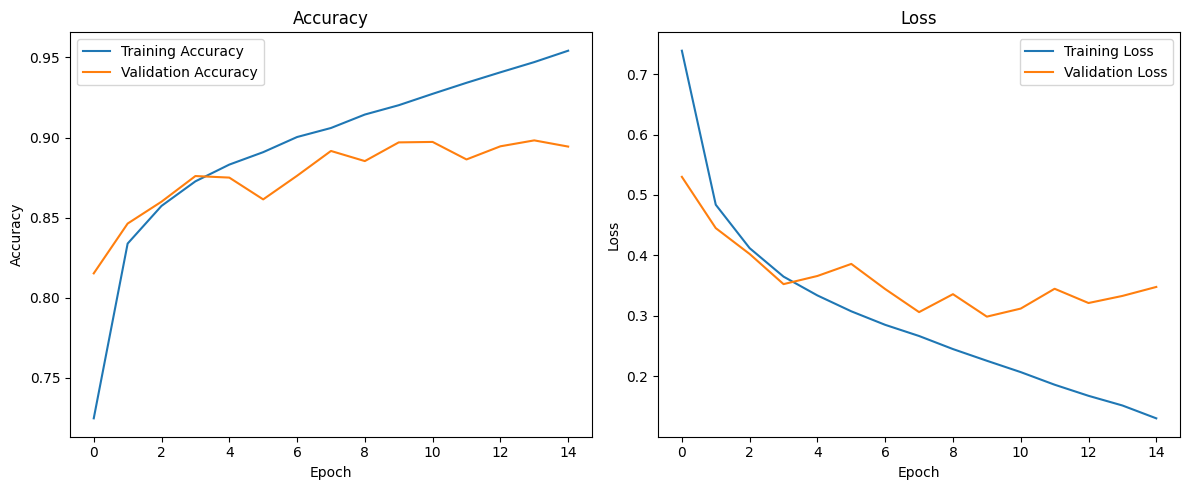

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Plot the training and validation metrics
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Predictions

305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9002

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      3341
           1       0.91      0.82      0.86      1051
           2       0.56      0.47      0.51       757
           3       0.92      0.95      0.93      4599

    accuracy                           0.90      9748
   macro avg       0.83      0.80      0.81      9748
weighted avg       0.90      0.90      0.90      9748



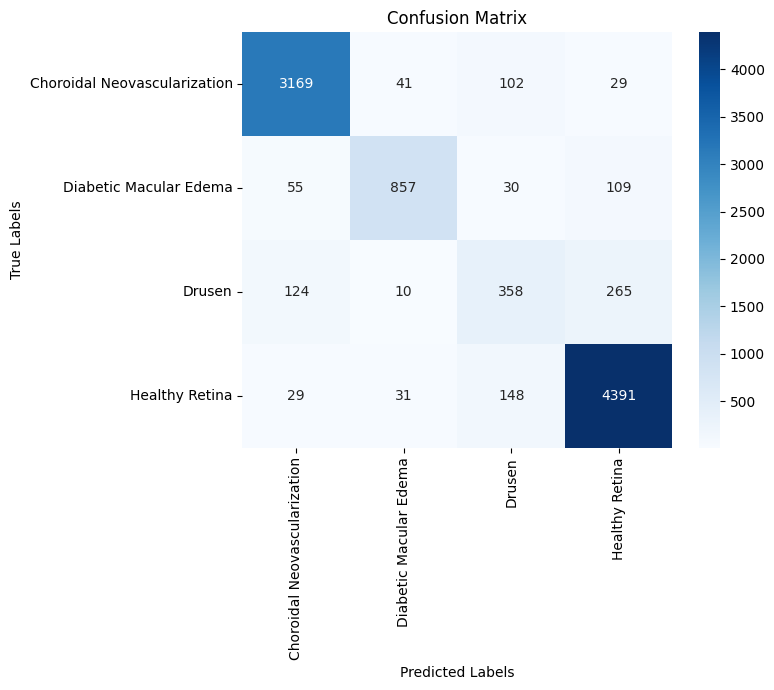

Class 0 F1-Score: 0.9434
Class 1 F1-Score: 0.8613
Class 2 F1-Score: 0.5133
Class 3 F1-Score: 0.9350


In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

def evaluate_on_test_set(model, X_test, y_test, class_names=['Choroidal Neovascularization', 'Diabetic Macular Edema', 'Drusen', 'Healthy Retina']):
    """
    Evaluate the model on a test set and compute comprehensive metrics.
    
    Parameters:
    - model: The trained model with a `predict` method for making predictions.
    - X_test: Test features (input).
    - y_test: Test labels (ground truth).
    - class_names: Optional list of class names for better visualization.
    
    Returns:
    - metrics_dict: A dictionary containing the computed metrics.
    """
    # Perform predictions
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=-1)
    
    # Compute metrics
    accuracy = accuracy_score(y_test, predicted_classes)
    precision = precision_score(y_test, predicted_classes, average=None, zero_division=0)  # Precision per class
    recall = recall_score(y_test, predicted_classes, average=None, zero_division=0)       # Recall per class
    f1_scores = f1_score(y_test, predicted_classes, average=None, zero_division=0)       # F1 per class
    
    # Compute Confusion Matrix
    cm = confusion_matrix(y_test, predicted_classes)
    
    # Print overall metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:\n{classification_report(y_test, predicted_classes, zero_division=0)}")
    
    # Visualize Confusion Matrix
    plt.figure(figsize=(8,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names or range(len(cm)),
                yticklabels=class_names or range(len(cm)))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()
    
    # Create metrics dictionary
    metrics_dict = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Scores": f1_scores,
        "Confusion_Matrix": cm
    }
    
    return metrics_dict


metrics = evaluate_on_test_set(model, X_test_labeled, y_test)

# Display the results
for i, f1 in enumerate(metrics["F1_Scores"]):
    print(f"Class {i} F1-Score: {f1:.4f}")


In [ ]:
import csv

def save_predictions_to_csv(model, X_test, output_file):
    """
    Perform inference using the given model on test data and save predictions to a CSV file.

    Parameters:
    - model: The trained model with an `infer` method for making predictions.
    - X_test: The test dataset to make predictions on.
    - output_file (str): Name of the CSV file to save the predictions.
    """
    # Perform inference
    predictions = model.predict(X_test)
    predictions = np.array(predictions)
    predicted_classes = predictions.argmax(axis=-1)

    # Save predictions to a CSV file
    with open(output_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["ID", "Class"])  # Header
        for i, pred in enumerate(predicted_classes):
            writer.writerow([i + 1, pred])

    print(f"Predictions saved to {output_file}")
    return predicted_classes

predicted_full = save_predictions_to_csv(model, X_test, "predictions_unet_augmented_full.csv")


In [ ]:
data = pd.read_csv("/kaggle/input/predictions-unet-augmented-half/predictions_unet_augmented.csv", usecols=['Class'], dtype={'Class':int}) 
predicted_benchmark = data['Class'].values
predicted_benchmark.shape

In [ ]:
new_data = pd.read_csv("/kaggle/input/predictions-unet-augmented-half/submission_CNN_augmented.csv", usecols=['Class'], dtype={'Class':int})
predicted_benchmark_CNN = new_data['Class'].values 
predicted_benchmark_CNN.shape

In [ ]:
print(np.sum(predicted_benchmark_CNN  == predicted_benchmark))
print(np.sum(predicted_benchmark == predicted_full))
print(np.sum(predicted_full == predicted_benchmark_CNN))

In [ ]:
weights = [2, 1, 1]  # Assign higher weight to CNN
stacked_predictions = np.stack([predicted_benchmark_CNN, predicted_benchmark, predicted_full], axis=0)
weighted_ensemble = np.apply_along_axis(
    lambda x: np.bincount(x, weights=weights).argmax(), axis=0, arr=stacked_predictions
)


# Assuming `final_predictions` is your NumPy array of predictions
final_predictions = weighted_ensemble  # Replace with your chosen prediction array

# Create a DataFrame
submission_df = pd.DataFrame({
    'ID': np.arange(1, len(final_predictions) + 1),  # ID starts from 1
    'Class': final_predictions
})

# Save to a CSV file
submission_df.to_csv('final_submission.csv', index=False)

print("Submission file saved as 'final_submission.csv'")


In [ ]:
np.sum(final_predictions == predicted_benchmark_CNN)